In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from scikeras.wrappers import KerasRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import make_scorer, get_scorer

In [2]:
df = pd.read_csv(r"..\..\oblig3_og_4\abalone.data", sep=",", names=["Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [3]:
df['Sex'] = pd.Series(LabelEncoder().fit_transform(df['Sex']))
features = pd.DataFrame(StandardScaler().fit_transform(df.drop(columns='Rings', axis=1)), columns=df.drop(columns='Rings', axis=1).columns)
targets = df['Rings']

In [4]:
len(targets)

4177

In [5]:
targets.dropna()

0       15
1        7
2        9
3       10
4        7
        ..
4172    11
4173    10
4174     9
4175    10
4176    12
Name: Rings, Length: 4177, dtype: int64

In [6]:
global_random_state = 15

scoring = {
    'mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': get_scorer('r2'),
}  

def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

def train(features, targets, estimator, params, scoring=scoring, refit='r2', random_state=global_random_state, outer_splits=5, inner_splits=4):

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=global_random_state)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=global_random_state)

    scores_train = []
    scores_test = []
    estimators = []
    cv_results = []

    # Loop through all test folds
    for (train_index, test_index) in outer_cv.split(features, targets):
        
        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise', 
            cv=inner_cv)
        grid.fit(features.iloc[train_index], targets.iloc[train_index])        
        
        evaluation_train = evaluate(grid, features.iloc[train_index], targets.iloc[train_index])
        evaluation_test = evaluate(grid, features.iloc[test_index], targets.iloc[test_index])
        
        scores_train.append(evaluation_train)
        scores_test.append(evaluation_test)
        
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))
        print("*")

    return estimators, pd.DataFrame(scores_train), pd.DataFrame(scores_test), pd.concat(cv_results, names=['test_split'], keys=range(outer_splits))

In [7]:
def create_model(optimizer='adam', activation='relu', loss='mean_squared_error', hidden_neurons1=64, hidden_neurons2=32):
    model = Sequential()
    model.add(Input(shape=(8,)))
    model.add(Dense(hidden_neurons1, activation=activation))
    if(hidden_neurons2 > 0):
        model.add(Dense(hidden_neurons2, activation=activation))
    model.add(Dense(8, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss, metrics=['mean_squared_error'])
    return model

ref: https://medium.com/@am.benatmane/keras-hyperparameter-tuning-using-sklearn-pipelines-grid-search-with-cross-validation-ccfc74b0ce9f

In [8]:
keras_reg_param = {
    'batch_size': [20],
    'epochs': [10], 
    'model__hidden_neurons1': [64],
    'model__hidden_neurons2': [32],
    'model__optimizer': ['rmsprop', 'adam'],
    'model__activation': ['relu','sigmoid', 'swish' , 'elu',],
    'model__loss': ['mean_squared_error', 'mean_absolute_error'],
}
model_keras_reg = KerasRegressor(model=create_model, verbose=0)
keras_reg_estimators, keras_reg_scores_train, keras_reg_scores_test, keras_reg_cv_results = train(features, targets, model_keras_reg, keras_reg_param, outer_splits=3, inner_splits=3)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


husk problmer med 'sgd' feil ut pga Nan verdier med denne i bruk.
https://www.geeksforgeeks.org/deep-learning/optimizers-in-tensorflow/


<Axes: xlabel='param_model__loss', ylabel='mean_test_r2'>

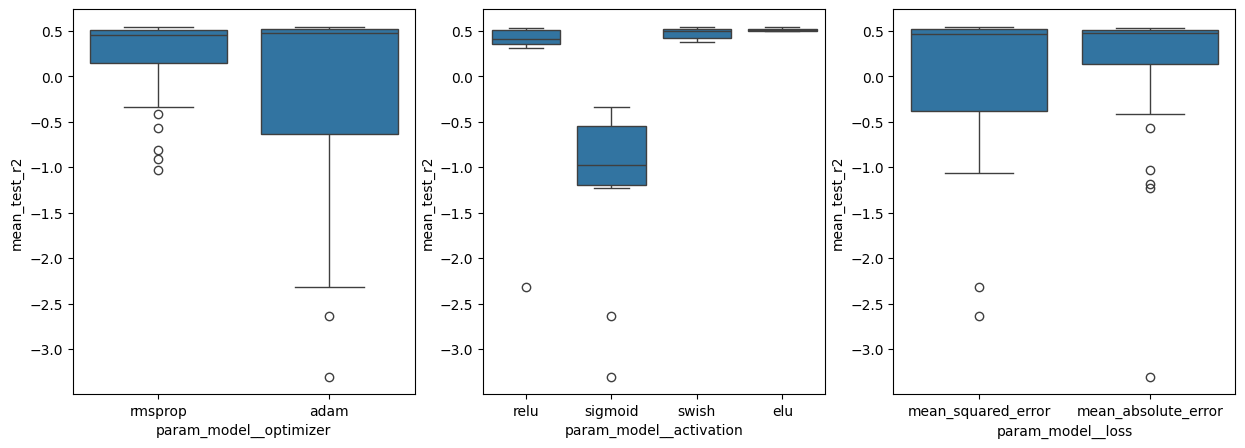

In [9]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.boxplot(data=keras_reg_cv_results, x='param_model__optimizer', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=keras_reg_cv_results, x='param_model__activation', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=keras_reg_cv_results, x='param_model__loss', y='mean_test_r2', ax=ax[2])

ut i fra resultatene i den første velger jeg å fjerne adagrad.... og sigmoid

In [10]:
keras_reg_scores_test

,mean_absolute_error,mean_squared_error,r2
0,-1.534523,-4.739657,0.550393
1,-1.557592,-4.483755,0.561726
2,-1.523827,-4.856032,0.533312


In [11]:
keras_reg_scores_train

,mean_absolute_error,mean_squared_error,r2
0,-1.525755,-4.470417,0.566736
1,-1.533548,-4.522211,0.568229
2,-1.516867,-4.556911,0.561267


In [13]:
keras_reg_estimators

[KerasRegressor(
 	model=<function create_model at 0x000001DC0A18A520>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=64
 	model__hidden_neurons2=32
 	model__loss=mean_squared_error
 	model__optimizer=adam
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001DC0A18A520>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=64
 	model__hidden_neurons2=32
 	model__loss=mean_squared_error
 	model__optimizer=adam
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001DC0A18A520>
 	build_fn=No

In [16]:
keras_reg_param = {
    'batch_size': [20],
    'epochs': [10], 
    'model__hidden_neurons1': [64],
    'model__hidden_neurons2': [32],
    'model__optimizer': ['rmsprop', 'adam'],
    'model__activation': ['relu', 'swish' , 'elu',],
    'model__loss': ['mean_squared_error', 'mean_absolute_error'],
}
keras_reg_estimators2, keras_reg_scores_train2, keras_reg_scores_test2, keras_reg_cv_results2 = train(features, targets, model_keras_reg, keras_reg_param, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


<Axes: xlabel='param_model__loss', ylabel='mean_test_r2'>

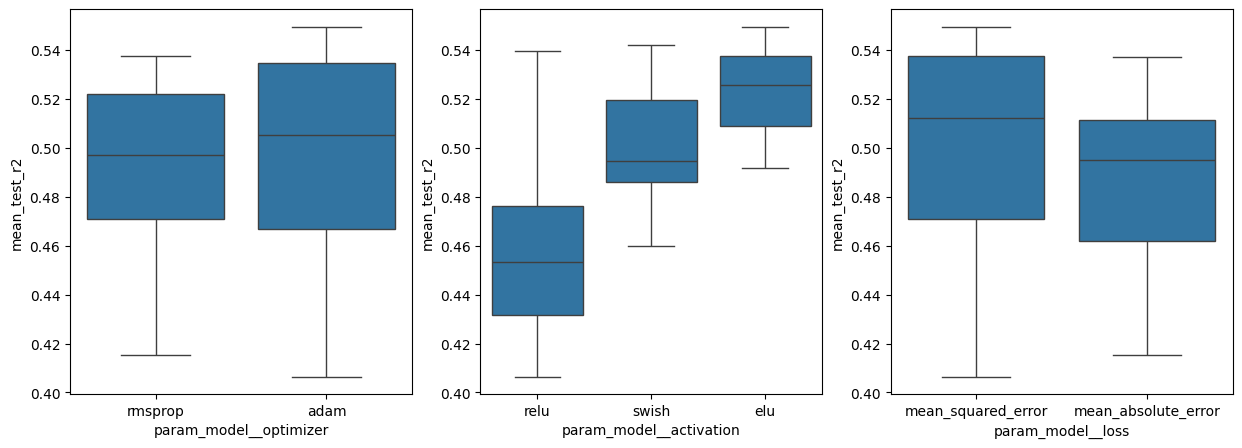

In [17]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.boxplot(data=keras_reg_cv_results2, x='param_model__optimizer', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=keras_reg_cv_results2, x='param_model__activation', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=keras_reg_cv_results2, x='param_model__loss', y='mean_test_r2', ax=ax[2])

In [18]:
keras_reg_scores_test2

,mean_absolute_error,mean_squared_error,r2
0,-1.664411,-5.216938,0.513907
1,-1.552455,-4.460842,0.566953
2,-1.567612,-4.454517,0.566009
3,-1.683334,-4.963964,0.523396
4,-1.536712,-5.831881,0.431027


In [19]:
keras_reg_scores_train2

,mean_absolute_error,mean_squared_error,r2
0,-1.587401,-4.580796,0.555593
1,-1.579043,-4.601333,0.558232
2,-1.579556,-4.617995,0.557024
3,-1.629776,-4.896456,0.528604
4,-1.520969,-4.516141,0.566936


In [26]:
keras_reg_estimators2

[KerasRegressor(
 	model=<function create_model at 0x000001DC0A18A520>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=64
 	model__hidden_neurons2=32
 	model__loss=mean_squared_error
 	model__optimizer=adam
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001DC0A18A520>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=64
 	model__hidden_neurons2=32
 	model__loss=mean_squared_error
 	model__optimizer=adam
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001DC0A18A520>
 	build_fn=No

In [27]:
keras_reg_param = {
    'batch_size': [20],
    'epochs': [10], 
    'model__hidden_neurons1': [64, 128, 192],
    'model__hidden_neurons2': [32, 48, 64],   
    'model__optimizer': ['adam'],
    'model__activation': ['elu',],
    'model__loss': ['mean_squared_error'],
}
keras_reg_estimators3, keras_reg_scores_train3, keras_reg_scores_test3, keras_reg_cv_results3 = train(features, targets, model_keras_reg, keras_reg_param, outer_splits=3, inner_splits=3)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


<Axes: xlabel='param_model__hidden_neurons2', ylabel='mean_test_r2'>

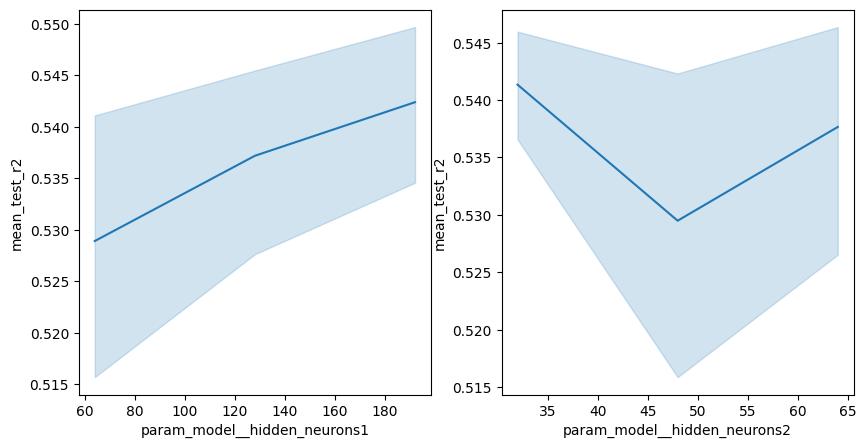

In [28]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_reg_cv_results3, x='param_model__hidden_neurons1', y='mean_test_r2', ax=ax[0])
sb.lineplot(data=keras_reg_cv_results3, x='param_model__hidden_neurons2', y='mean_test_r2', ax=ax[1])

In [29]:
keras_reg_scores_test3

,mean_absolute_error,mean_squared_error,r2
0,-1.669789,-5.151206,0.511353
1,-1.644484,-4.627672,0.547658
2,-1.535494,-4.954249,0.523873


In [30]:
keras_reg_scores_train3

,mean_absolute_error,mean_squared_error,r2
0,-1.610986,-4.659065,0.548453
1,-1.633311,-4.642732,0.556721
2,-1.519253,-4.552627,0.561679


In [32]:
keras_reg_estimators3

[KerasRegressor(
 	model=<function create_model at 0x000001DC0A18A520>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=192
 	model__hidden_neurons2=48
 	model__loss=mean_squared_error
 	model__optimizer=adam
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001DC0A18A520>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=192
 	model__hidden_neurons2=32
 	model__loss=mean_squared_error
 	model__optimizer=adam
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001DC0A18A520>
 	build_fn=

In [34]:
keras_reg_param = {
    'batch_size': [10, 20, 30],
    'epochs': [10], 
    'model__hidden_neurons1': [160, 192, 224],
    'model__hidden_neurons2': [32],   
    'model__optimizer': ['adam'],
    'model__activation': ['elu',],
    'model__loss': ['mean_squared_error'],
}
keras_reg_estimators4, keras_reg_scores_train4, keras_reg_scores_test4, keras_reg_cv_results4 = train(features, targets, model_keras_reg, keras_reg_param, outer_splits=3, inner_splits=3)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


<Axes: xlabel='param_batch_size', ylabel='mean_test_r2'>

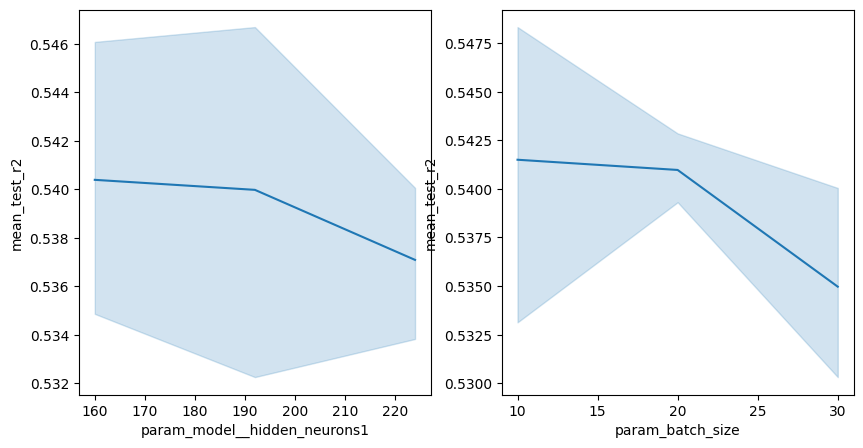

In [35]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_reg_cv_results4, x='param_model__hidden_neurons1', y='mean_test_r2', ax=ax[0])
sb.lineplot(data=keras_reg_cv_results4, x='param_batch_size', y='mean_test_r2', ax=ax[1])

In [36]:
keras_reg_scores_test4

,mean_absolute_error,mean_squared_error,r2
0,-1.599875,-4.78213,0.546364
1,-1.518354,-4.51829,0.558350
2,-1.698161,-5.29594,0.491035


In [37]:
keras_reg_scores_train4

,mean_absolute_error,mean_squared_error,r2
0,-1.584796,-4.449726,0.568741
1,-1.487012,-4.592617,0.561506
2,-1.733988,-5.243106,0.495201


In [40]:
keras_reg_estimators4

[KerasRegressor(
 	model=<function create_model at 0x000001DC0A18A520>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=192
 	model__hidden_neurons2=32
 	model__loss=mean_squared_error
 	model__optimizer=adam
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001DC0A18A520>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=160
 	model__hidden_neurons2=32
 	model__loss=mean_squared_error
 	model__optimizer=adam
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001DC0A18A520>
 	build_fn=

In [41]:
def create_model2(activation='relu', loss='mean_squared_error', hidden_neurons1=64, hidden_neurons2=32, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(8,)))
    model.add(Dense(hidden_neurons1, activation=activation))
    if(hidden_neurons2 > 0):
        model.add(Dense(hidden_neurons2, activation=activation))
    model.add(Dense(8, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss, metrics=['mean_squared_error'])
    return model

In [ ]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [10], 
    'model__hidden_neurons1': [160],
    'model__hidden_neurons2': [32, 64, 96],
    'model__activation': ['elu'],
    'model__loss': ['mean_squared_error'],
    'model__learning_rate': [0.0005, 0.001, 0.005, 0.0075, 0.01],
}
model_keras_reg2 = KerasRegressor(create_model2, verbose=0)
keras_reg_estimators5, keras_reg_scores_train5, keras_reg_scores_test5, keras_reg_cv_results5 = train(features, targets, model_keras_reg2, keras_reg_param, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


<Axes: xlabel='param_model__learning_rate', ylabel='mean_test_r2'>

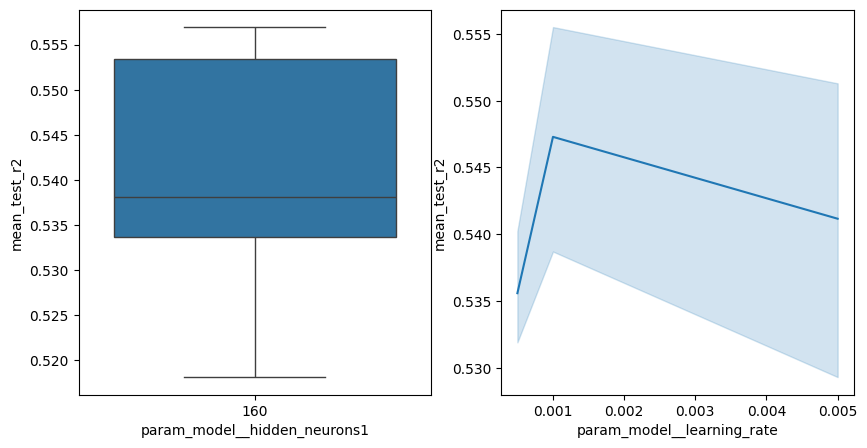

In [44]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.boxplot(data=keras_reg_cv_results5, x='param_model__hidden_neurons1', y='mean_test_r2', ax=ax[0])
sb.lineplot(data=keras_reg_cv_results5, x='param_model__learning_rate', y='mean_test_r2', ax=ax[1])

In [45]:
keras_reg_scores_test5

,mean_absolute_error,mean_squared_error,r2
0,-1.526881,-4.972586,0.536675
1,-1.509010,-4.367062,0.576057
2,-1.495899,-4.488374,0.562711
3,-1.537840,-4.539801,0.564121
4,-1.523492,-4.430465,0.567753


In [46]:
keras_reg_scores_train5

,mean_absolute_error,mean_squared_error,r2
0,-1.496957,-4.472014,0.566147
1,-1.531168,-4.557373,0.562452
2,-1.474066,-4.536005,0.564889
3,-1.506377,-4.476732,0.569012
4,-1.524043,-4.471012,0.571264


In [48]:
keras_reg_estimators5

[KerasRegressor(
 	model=<function create_model2 at 0x000001DD60F90540>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=160
 	model__hidden_neurons2=32
 	model__learning_rate=0.001
 	model__loss=mean_squared_error
 ),
 KerasRegressor(
 	model=<function create_model2 at 0x000001DD60F90540>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=160
 	model__hidden_neurons2=32
 	model__learning_rate=0.0005
 	model__loss=mean_squared_error
 ),
 KerasRegressor(
 	model=<function create_model2 at 0x000001DD60F9054

In [ ]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [10], 
    'model__hidden_neurons1': [160],
    'model__hidden_neurons2': [32, 64, 96],
    'model__activation': ['elu'],
    'model__loss': ['mean_squared_error'],
    'model__learning_rate': [0.0008, 0.001, 0.002, 0.003],
}
keras_reg_estimators6, keras_reg_scores_train6, keras_reg_scores_test6, keras_reg_cv_results6 = train(features, targets, model_keras_reg2, keras_reg_param, outer_splits=3, inner_splits=3)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


<Axes: xlabel='param_model__activation', ylabel='mean_test_r2'>

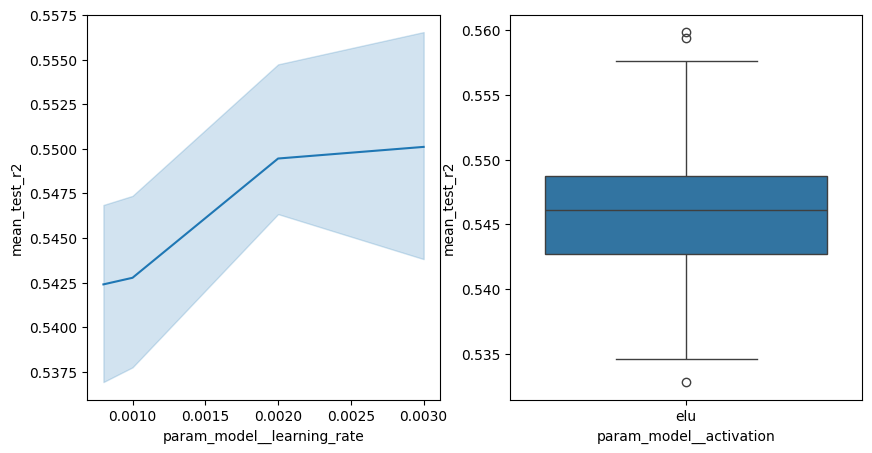

In [57]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_reg_cv_results6, x='param_model__learning_rate', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=keras_reg_cv_results6, x='param_model__activation', y='mean_test_r2', ax=ax[1])

In [58]:
keras_reg_scores_test6

,mean_absolute_error,mean_squared_error,r2
0,-1.525328,-5.029430,0.531378
1,-1.528543,-4.458908,0.567141
2,-1.610027,-4.593338,0.552484
3,-1.483519,-4.620082,0.556413
4,-1.591513,-4.549385,0.556151


In [59]:
keras_reg_scores_train6

,mean_absolute_error,mean_squared_error,r2
0,-1.483529,-4.571318,0.556513
1,-1.567684,-4.583446,0.559949
2,-1.568944,-4.536180,0.564872
3,-1.475646,-4.622398,0.554989
4,-1.560880,-4.489087,0.569530


In [61]:
keras_reg_estimators6

[KerasRegressor(
 	model=<function create_model2 at 0x000001DD60F90540>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=160
 	model__hidden_neurons2=32
 	model__learning_rate=0.003
 	model__loss=mean_squared_error
 ),
 KerasRegressor(
 	model=<function create_model2 at 0x000001DD60F90540>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=160
 	model__hidden_neurons2=32
 	model__learning_rate=0.002
 	model__loss=mean_squared_error
 ),
 KerasRegressor(
 	model=<function create_model2 at 0x000001DD60F90540

In [62]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [10], 
    'model__hidden_neurons1': [160],
    'model__hidden_neurons2': [24, 32, 48],
    'model__activation': ['elu'],
    'model__loss': ['mean_squared_error'],
    'model__learning_rate': [0.002, 0.003, 0.004],
}
keras_reg_estimators7, keras_reg_scores_train7, keras_reg_scores_test7, keras_reg_cv_results7 = train(features, targets, model_keras_reg2, keras_reg_param, outer_splits=3, inner_splits=3)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


<Axes: xlabel='param_model__learning_rate', ylabel='mean_test_r2'>

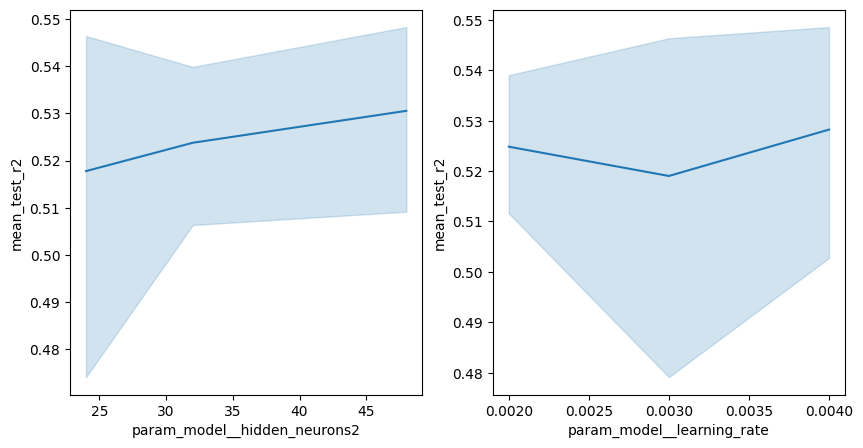

In [64]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_reg_cv_results7, x='param_model__hidden_neurons2', y='mean_test_r2', ax=ax[0])
sb.lineplot(data=keras_reg_cv_results7, x='param_model__learning_rate', y='mean_test_r2', ax=ax[1])

In [65]:
keras_reg_scores_test7

,mean_absolute_error,mean_squared_error,r2
0,-1.520884,-4.656758,0.558256
1,-1.507459,-4.350117,0.574789
2,-1.491030,-4.856985,0.533220


In [66]:
keras_reg_scores_train7

,mean_absolute_error,mean_squared_error,r2
0,-1.512250,-4.348035,0.578597
1,-1.480525,-4.359725,0.583742
2,-1.485521,-4.623990,0.554808


In [68]:
keras_reg_estimators7

[KerasRegressor(
 	model=<function create_model2 at 0x000001DD60F90540>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=160
 	model__hidden_neurons2=48
 	model__learning_rate=0.004
 	model__loss=mean_squared_error
 ),
 KerasRegressor(
 	model=<function create_model2 at 0x000001DD60F90540>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=160
 	model__hidden_neurons2=24
 	model__learning_rate=0.002
 	model__loss=mean_squared_error
 ),
 KerasRegressor(
 	model=<function create_model2 at 0x000001DD60F90540

In [70]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [10], 
    'model__hidden_neurons1': [160],
    'model__hidden_neurons2': [24, 48, 72, 96],
    'model__activation': ['elu'],
    'model__loss': ['mean_squared_error'],
    'model__learning_rate': [0.004, 0.005],
}
keras_reg_estimators8, keras_reg_scores_train8, keras_reg_scores_test8, keras_reg_cv_results8 = train(features, targets, model_keras_reg2, keras_reg_param, outer_splits=3, inner_splits=3)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


<Axes: xlabel='param_model__learning_rate', ylabel='mean_test_r2'>

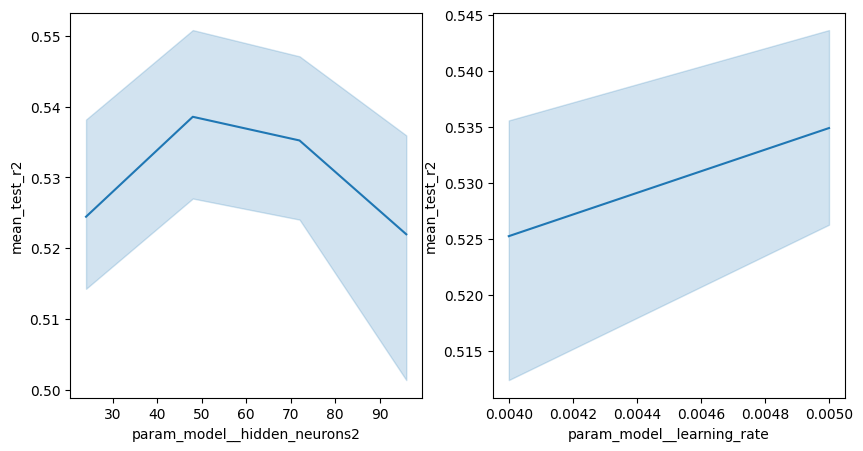

In [71]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_reg_cv_results8, x='param_model__hidden_neurons2', y='mean_test_r2', ax=ax[0])
sb.lineplot(data=keras_reg_cv_results8, x='param_model__learning_rate', y='mean_test_r2', ax=ax[1])

In [72]:
keras_reg_scores_test8

,mean_absolute_error,mean_squared_error,r2
0,-1.503060,-4.758123,0.548641
1,-1.518508,-4.527141,0.557485
2,-1.499129,-5.092813,0.510556


In [73]:
keras_reg_scores_train8

,mean_absolute_error,mean_squared_error,r2
0,-1.477588,-4.335985,0.579765
1,-1.502352,-4.578093,0.562893
2,-1.488148,-4.772638,0.540497


In [75]:
keras_reg_estimators8

[KerasRegressor(
 	model=<function create_model2 at 0x000001DD60F90540>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=160
 	model__hidden_neurons2=72
 	model__learning_rate=0.005
 	model__loss=mean_squared_error
 ),
 KerasRegressor(
 	model=<function create_model2 at 0x000001DD60F90540>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=160
 	model__hidden_neurons2=96
 	model__learning_rate=0.005
 	model__loss=mean_squared_error
 ),
 KerasRegressor(
 	model=<function create_model2 at 0x000001DD60F90540

In [76]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [10], 
    'model__hidden_neurons1': [160],
    'model__hidden_neurons2': [48, 72],
    'model__activation': ['elu'],
    'model__loss': ['mean_squared_error'],
    'model__learning_rate': [0.005, 0.0075, 0.01],
}
keras_reg_estimators9, keras_reg_scores_train9, keras_reg_scores_test9, keras_reg_cv_results9 = train(features, targets, model_keras_reg2, keras_reg_param, outer_splits=3, inner_splits=3)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


<Axes: xlabel='param_model__learning_rate', ylabel='mean_test_r2'>

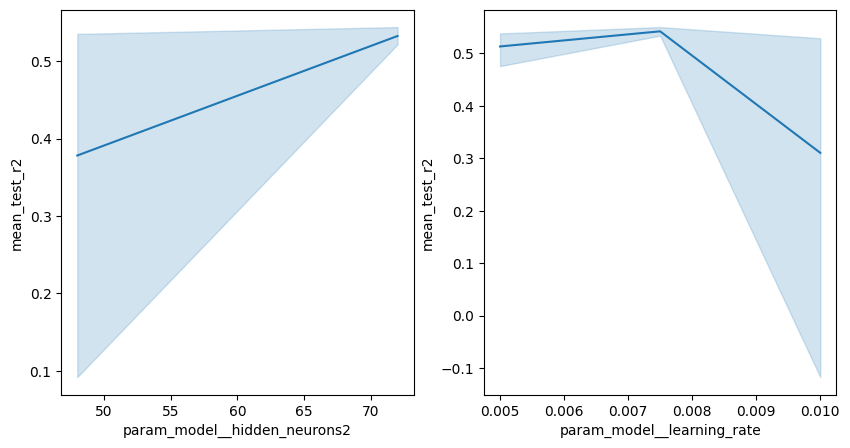

In [77]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_reg_cv_results9, x='param_model__hidden_neurons2', y='mean_test_r2', ax=ax[0])
sb.lineplot(data=keras_reg_cv_results9, x='param_model__learning_rate', y='mean_test_r2', ax=ax[1])

In [78]:
keras_reg_scores_test9

,mean_absolute_error,mean_squared_error,r2
0,-1.523477,-4.931781,0.532168
1,-1.520609,-4.477296,0.562357
2,-1.559332,-5.360358,0.484844


In [79]:
keras_reg_scores_train9

,mean_absolute_error,mean_squared_error,r2
0,-1.486036,-4.450036,0.568711
1,-1.510477,-4.509480,0.569444
2,-1.541164,-5.125782,0.506496


In [80]:
keras_reg_estimators9

[KerasRegressor(
 	model=<function create_model2 at 0x000001DD60F90540>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=160
 	model__hidden_neurons2=48
 	model__learning_rate=0.0075
 	model__loss=mean_squared_error
 ),
 KerasRegressor(
 	model=<function create_model2 at 0x000001DD60F90540>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=160
 	model__hidden_neurons2=72
 	model__learning_rate=0.0075
 	model__loss=mean_squared_error
 ),
 KerasRegressor(
 	model=<function create_model2 at 0x000001DD60F905

input = Input(shape=(28,28,1))
flatten = Flatten()
dense1 = Dense(380)(flatten)
dense2 = Dense(180)(dense1) + Dense(180)(flatten)
output = Dense(10, activation='softmax')

model = tf.keras.models.Model(input=input, outputs=output)